# Downloading products from GEE into netcdfs

Using package `wxee`: https://github.com/aazuspan/wxee

The default example loads `MODIS Terra thermal anomalies and Fire Daily`

> Note: Will likely need to install the two packages listed in the cell below. Uncomment, run the cell, then restart kernel.

## Load packages

In [3]:
import xarray as xr
ds = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/5km/ESA_worldcover_5km_monthly_2002_2021.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:      (latitude: 3400, longitude: 4200)
Coordinates:
  * latitude     (latitude) float64 -10.01 -10.02 -10.03 ... -43.98 -43.99
  * longitude    (longitude) float64 112.0 112.0 112.0 ... 154.0 154.0 154.0
    spatial_ref  int32 4326
    time         datetime64[ns] 2020-01-01
Data variables:
    Map          (latitude, longitude) float64 nan nan nan nan ... nan nan nan
Attributes:
    transform:               [ 1.000e+03  0.000e+00 -2.023e+06  0.000e+00 -1....
    crs:                     +init=epsg:3577
    res:                     [1000. 1000.]
    is_tiled:                1
    nodatavals:              -32768.0
    scales:                  1.0
    offsets:                 0.0
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

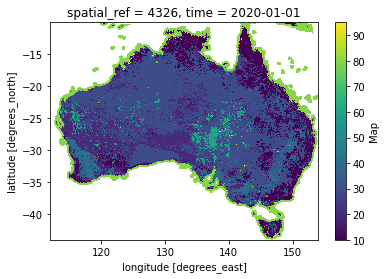

In [5]:
ds.Map.plot.imshow()

In [ ]:
import os
import ee
import wxee
import xarray as xr
import pandas as pd
import numpy as np

import rioxarray
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

## Authenticate GEE    

Need to sign up: https://earthengine.google.com/new_signup/

Then run the cell and follow the link/prompts

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

## Analysis parameters

Enter the product name and other parameters below, you find some of this info on the product data page, e.g. https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD14A1?hl=en

> Note: For the analysis extent try using http://geojson.io/ to draw a polygon, then copy and paste the coordinates into the cell

In [ ]:
product = "MODIS/006/MOD44B"
bands =  ['Percent_NonVegetated']# 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']
start_date = '1/1/2002'
end_date = '12/31/2021'
output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/NonVegetated_cover/'
output_crs = "EPSG:3577"
resolution = 1000
scale = 1

# ~Aus region (slightly less to trick google into giving me 1km res)
region = ee.Geometry.Polygon([[
            [114,-43.0],
            [153.0,-43.0],
            [153.0,-10.0],
            [114,-10.0],
            [114,-43.0]]])


## Loop through months and load MODIS data

Doing this on a per-month basis to keep the memory usage down

In [ ]:
#use start and end dates to loop through months and load GEE data
start = pd.date_range(start=start_date, end=end_date, freq='YS') 
end = pd.date_range(start=start_date, end=end_date, freq='Y')

i = 0
for s, e in zip(start,end):
    print(" {:03}/{:03}\r".format(i+1, len(start)), end="")
    
    # use this to check if file already exists
    ss = s#+pd.Timedelta(14, 'd')

    if os.path.isfile(output_path+product[-6:]+'_'+ss.strftime('%Y')+'.nc'):
        pass
    
    else:
        try:
            s = s.strftime('%Y-%m-%d')
            e = e.strftime('%Y-%m-%d')

            #download data from GEE
            ts = wxee.TimeSeries(product).filterDate(s, e)
            ts = ts.select(bands)
            ds = ts.wx.to_xarray(region=region, scale=resolution, crs=output_crs, progress=False)
            #ds = ds[bands] * scale # scale values 
            attrs=ds.attrs #extract attributes so we don't loose them
            ds = assign_crs(ds, crs=output_crs) #add geobox
            #ds = ds.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean() #resample to monthly

            lst = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/LST/LST_MODIS_1km_month_2002.nc').isel(time=0) #use this to reproject too
            ds = xr_reproject(ds, geobox=lst.geobox, resampling='bilinear') #reproject
            ds['latitude'] = ds.latitude.astype('float32')
            ds['longitude'] = ds.longitude.astype('float32')
            #ds = ds.where(ds!=0) # remove spurious zeros from reprojection
            ds = ds.assign_attrs(attrs) #add back attrs

            ds.to_netcdf(output_path+product[-6:]+'_'+np.datetime_as_string(ds.time.values[0], unit='Y')+'.nc')
    
        except:
            print('fail:', s,e)
            pass
        
    i+=1

## Optional: Stitch together monthly files into annual netcdfs

Set the three parameters below

In [ ]:
year_start = 2002
year_end = 2021
annual_output_path = '/g/data/os22/chad_tmp/NEE_modelling/data/LAI-annual/'

In [ ]:
i=0
for y in range(year_start, year_end+1):
    print(" {:02}/{:02}\r".format(i + 1, len(range(year_start, year_end+1))), end="")
    
    year = str(y)
    files = [output_path+f for f in os.listdir(output_path) if year in f]
    
    dss=[]
    for f in files:
        ds = xr.open_dataset(f)
        dss.append(ds)
        
    data = xr.concat(dss, dim='time').sortby('time')
    data['latitude'] = data.latitude.astype('float32')
    data['longitude'] = data.longitude.astype('float32')

    data.to_netcdf(annual_output_path+product[-8:]+'_'+year+'.nc')
    i+=1